This accompanies the paper "Recovering semipermeable barriers from reflected Brownian motion" by Alexander Van Werde and Jaron Sanders (2024). That paper studied _reflected Brownian motion with semipermeable barriers_ in a planar domain, particularly the recovery of barrier locations based on an observed trajectory.  

The current notebook provides examples showing how the module _brownian\_barrier_ can be used to recover barriers based on an observed trajectory, and how to simulate a trajectory given barrier locations. We refer to the aforementioned paper for rigorous details about the process and algorithm. The recovery algorithm used in this notebook is Algorithm 1 in the paper. 


The library brownian_barrier relies on the Python Optimal Transport library (POT) for computing Wasserstein distances (https://pythonot.github.io/). You will likely first have to install this using "pip install POT". The following libraries are also used: numpy, scipy, xml, svg, and typing.

In [1]:
import brownian_barrier as bb  

import numpy as np
import matplotlib.pyplot as plt 

# Examples: barrier recovery

For convenience, this notebook comes with a saved trajectory. Code to simulate a new trajectory can also be found below.

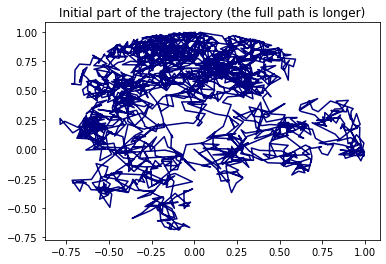

In [2]:
path = np.load("example_path.npy")

# Visualize the first 2000 datapoints 
initial_part  = path[0:2000]
plt.plot(initial_part[:,0],initial_part[:,1],color = "navy")
plt.title("Initial part of the trajectory (the full path is longer)")
plt.show()

There are two main parameters which have to be chosen in the detection algorithm. The first is the discretization scale, which determines how precise an estimate of the barriers is desired. The second is the sensitivity threshold. 

The discretization scale should be chosen such that it is reasonable to expect that each square box of that size has a nontrivial number of observed datapoints so that concentration of the associated empirical transition kernels may occur. The choice of the sensitivity threshold typically requires some manual searching. The following allows one to search through choices of the sensitivity threshold without having to recompute anything. 

It is still necessary to compute anew when changing the discretization scale. Regarding the latter, it is useful to keep in mind that the computation time  will typically be _larger_ when the discretization scale is taken coarser. (This is because computation of the Wasserstein distance is the most expensive part of the algorithm, and its computation time depends on the number of datapoints per box.) Hence, it is typically best to start with a fairly small discretization scale and incrementally increase to reduce obvious false positives.  

In [3]:
# The following is a "good" value for the discretization scale given the provided amount of data. 
# This will take some time to compute, depending on the available hardware. It takes about 10 to 15 minutes on my laptop which has a 9th generation Intel i7 processor. 

# It is instructive to change this to a smaller value. Then, one will see some obvious false positives below because there is insufficient averaging to reduce noise.

discretization_scale = 0.015
wasserstein_rates = bb.get_wasserstein_change_field([path],discretization_scale) 

In [4]:
# The following is an arbitrary "good" value for the sensitivity threshold given a discretization scale of 0.015 and the provided trajectory. 
# Again, it may be instructive to play around with different choices of the parameter. 

sensitivity_threshold = 0.0825
detected_points = [xy for xy in wasserstein_rates.keys() if wasserstein_rates[xy]>=sensitivity_threshold]

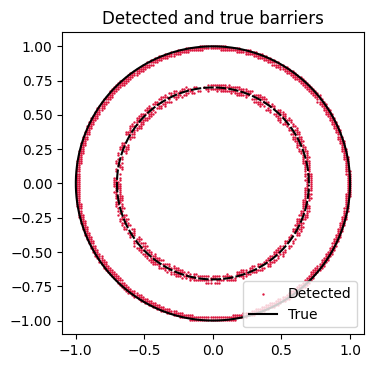

In [5]:
# Visualize 
fig, ax = plt.subplots(dpi = 100)
ax.set_aspect("equal")

# Output 
plt.scatter([xy[0] for xy in detected_points], [xy[1] for xy in detected_points], color = "crimson", s=0.5,label = "Detected")

# Truth
num_barrier_points = 500 
angles = [2*np.pi*i/num_barrier_points for i in range(num_barrier_points)]
barriers = np.array([[(np.cos(t),np.sin(t)) for t in angles],[(0.7*np.cos(t),0.7*np.sin(t)) for t in angles]])  
plt.plot(barriers[0,:,0],barriers[0,:,1], color = "Black", label = "True")
plt.plot(barriers[1,:,0],barriers[1,:,1], color = "Black", linestyle = (0, (5, 1)))
plt.title("Detected and true barriers")
plt.legend(loc = "lower right")
plt.show()

We see that this example had two circular barriers: an impermeable outer barrier with radius 1, and a permeable barrier with radius 0.7. 

If one knows what discretization scale and sensitivity threshold is appropriate, then the function recover\_barriers\_wasserstein combines the preceding steps:

In [6]:
discretization_scale = 0.015
sensitivity_threshold = 0.0825


detected_points = list(bb.recover_barriers_wasserstein([path],sensitivity_threshold,discretization_scale))

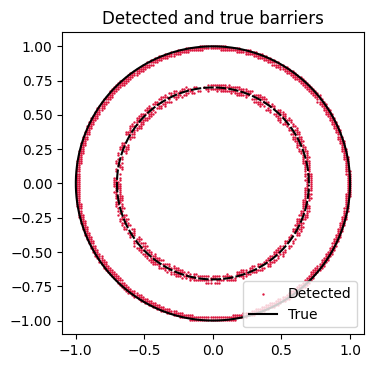

In [7]:
# Visualize 
fig, ax = plt.subplots(dpi = 100)
ax.set_aspect("equal")

# Output 
plt.scatter([xy[0] for xy in detected_points], [xy[1] for xy in detected_points], color = "crimson", s=0.5,label = "Detected")

# Truth
num_barrier_points = 500 
angles = [2*np.pi*i/num_barrier_points for i in range(num_barrier_points)]
barriers = np.array([[(np.cos(t),np.sin(t)) for t in angles],[(0.7*np.cos(t),0.7*np.sin(t)) for t in angles]])  
plt.plot(barriers[0,:,0],barriers[0,:,1], color = "Black", label = "True")
plt.plot(barriers[1,:,0],barriers[1,:,1], color = "Black", linestyle = (0, (5, 1)))
plt.title("Detected and true barriers")
plt.legend(loc = "lower right")
plt.show()

# Examples: simulation

Here are some examples for generating samples from a reflected Brownian motion with specified permeable barriers. 

The employed simulation scheme relies on a local approximation of the barriers by straight lines. The main parameter which can be tuned is the scale at which that local approximation scale is done. Taking the parameter approximation\_radius smaller will generally result in a more accurate simulation. 

The computation time is mostly determined by to the number of samples which is desired. Reducing the approximation radius indirectly affects this: the simulation scheme requires that the time increment between samples is taken sufficiently small so that the distance between subsequent samples does not exceed the approximation radius with fairly high probability. 

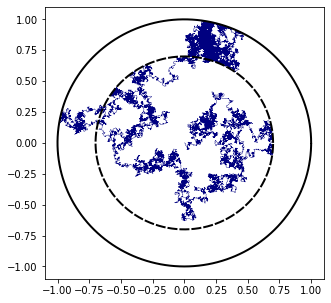

In [8]:
# Example of simulating the process in a circular domain
# Takes about 10 seconds on my laptop 

num_barrier_points = 500 
angles = [2*np.pi*i/num_barrier_points for i in range(num_barrier_points)]
barriers = [[(np.cos(t),np.sin(t)) for t in angles], [(0.7*np.cos(t),0.7*np.sin(t)) for t in angles]]  

initial_condition = (0,-0)
permeabilities = [[0,0],[4,4]]
observation_time = 1
approximation_radius = 0.04
time_increment = approximation_radius**2/50

num_samples = int(observation_time/time_increment)
np.random.seed(1)
path = bb.get_sample_path(initial_condition, time_increment, approximation_radius, num_samples, barriers, permeabilities)
path = np.array(path)

plt.figure(figsize=(5,5))
plt.plot(path[:,0], path[:,1], linewidth = 0.4, color = "Navy")
for k in range(len(barriers)):
    B = np.array(barriers[k])
    if k == 0:
        plt.plot(B[:,0],B[:,1], color = "Black", linewidth = 2)
    else: 
        plt.plot(B[:,0],B[:,1], color = "Black", linewidth = 2,  linestyle = (0, (5, 1)))
plt.show()

Entering barriers with explicit parametric equations can be inconvenient if non-trivial shapes are desired. A more convenient method is provided by the method svg_to_barriers which takes a .svg file and returns the coordinates of the nodes of the drawn curves.

Suitable .svg files can be created in a vector drawing program such as inkscape. The employed procedure is as follows: (1) Open a new file and draw the desired barriers. (2) Ensure that there are enough nodes. To do this, add equally spaced points using Extensions>Modify Path>Add Nodes. (3) Save as a .svg file.    


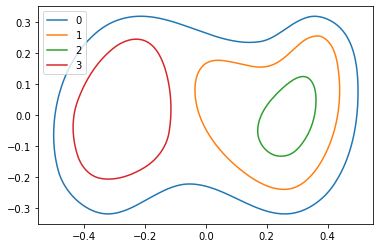

In [9]:
# Example of how to import custom barriers from a svg file

file_path = "Barriers/egg_n_bacon.svg"
barriers = bb.svg_to_barriers(file_path)

plt.figure()
for i in range(len(barriers)):
    plt.plot(barriers[i][:,0],barriers[i][:,1],   label = str(i))
plt.legend()
plt.show()

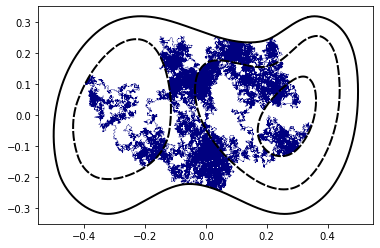

In [10]:
# Simulation with above barriers
# Takes about 30 seconds on my laptop 

initial_condition = (-0.3,0)
permeabilities = [[0,0],[10,10],[10,10],[10,10]]
observation_time = 0.5
approximation_radius = 0.02
time_increment = approximation_radius**2/50

num_samples = int(observation_time/time_increment)
np.random.seed(1)
path = bb.get_sample_path(initial_condition, time_increment, approximation_radius, num_samples, barriers, permeabilities)
path = np.array(path)

plt.plot(path[:,0], path[:,1], linewidth = 0.4, color = "Navy")
for k in range(len(barriers)):
    B = np.array(barriers[k])
    if k == 0:
        plt.plot(B[:,0],B[:,1], color = "Black", linewidth = 2)
    else: 
        plt.plot(B[:,0],B[:,1], color = "Black", linewidth = 2,  linestyle = (0, (5, 1)))
plt.show()

# Addendum: the provided example trajectory

The code and parameters which were used to generate the provided example trajectory (example\_path.npy) may be found below. 

In [11]:
num_barrier_points = 500 
angles = [2*np.pi*i/num_barrier_points for i in range(num_barrier_points)]
barriers = [[(np.cos(t),np.sin(t)) for t in angles], [(0.7*np.cos(t),0.7*np.sin(t)) for t in angles]]  

initial_condition = (0,-0)
permeabilities = [[0,0],[4,4]]
observation_time = 1 

# The full generated data uses the following parameter. (Note: takes a long time.)  
# observation_time = 10000

approximation_radius = 0.1
time_increment = approximation_radius**2/10
num_samples = int(observation_time/time_increment)
np.random.seed(1)
path = bb.get_sample_path(initial_condition, time_increment, approximation_radius, num_samples, barriers, permeabilities)
path = np.array(path)

path = path[::5]

# np.save("example_path.npy",path, allow_pickle = False)